In [1109]:
import io
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import sentencepiece as spm
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

### Preprocess the Data

In [1110]:
def dataframe_sentence_generator(df):
    for sentence in df:
        yield sentence.lower()

# Replace 'your_file.csv' with the path to your CSV file
# file_path = './TitlesAndScoreALL.csv'
file_path = './DatasetWithURLsInside.csv'
df = pd.read_csv(file_path, sep=',')
df['title'] = df['title'] + ' ' + df['url'].astype(str)
# df['title'] = df['title'] + ' ' + df['score'].astype(str)

# Split the data into training and test sets
train_texts, test_texts, train_score, test_score = train_test_split(
    df['title'], 
    df['score'], 
    test_size=0.5, 
    random_state=42
)

print(train_texts)

30050     Is it time for profile pictures in Hacker News...
18525     Click on the lady who looks better.. so hot an...
163374    Rumor $800 Apple Tablet Coming In The Fall htt...
95498     Java/Ruby does not generalise to static/dynami...
162511    We know almost nothing about Chrome OS. http:/...
                                ...                        
119879    Broadcast Your Location To Friends With Google...
103694    The curious case of the Microsoft Zune phone h...
131932    Custom Software Development and Design http://...
146867    Airbus pictured booting Linux 2.4 http://zefon...
121958    Another little IBM deal http://www.roughtype.c...
Name: title, Length: 82710, dtype: object


### Train a SentencePiece Model

In [1111]:
spm.SentencePieceTrainer.train(
    sentence_iterator=dataframe_sentence_generator(train_texts), 
    model_prefix='spm_Alex_week2', 
    vocab_size=15000,
)

sp = spm.SentencePieceProcessor()
sp.load('spm_Alex_week2.model')

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: spm_Alex_week2
  model_type: UNIGRAM
  vocab_size: 15000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy

True

### Generate  Tokens

In [1112]:
tokenized_titles = []
for title in train_texts:
    tokanized_title = sp.encode_as_pieces(title)
    tokenized_titles.append(tokanized_title)

### Use Word2Vec to Generate Embeddings

In [1113]:
vector_size = 150
w2v_model = Word2Vec(
    sentences=tokenized_titles, 
    vector_size=vector_size, 
    window=5, 
    min_count=1, 
    workers=4,
    sg=1,
)

In [1114]:
def title_to_embedding(sp, title, vector_size):
    tokens = sp.encode_as_pieces(title)

    embeddings = []
    for token in tokens:
        if (token in w2v_model.wv): 
            embeddings.append(w2v_model.wv[token])

    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

### Create a PyTorch Dataset

In [1115]:
training_embeddings = np.empty((len(train_texts), vector_size), dtype=np.float64)
testing_embeddings = np.empty((len(test_texts), vector_size), dtype=np.float64)

for idx, title in enumerate(train_texts):
    training_embeddings[idx] = title_to_embedding(sp, title, vector_size)

for idx, title in enumerate(test_texts):
    testing_embeddings[idx] = title_to_embedding(sp, title, vector_size)

print(training_embeddings.shape)
print(testing_embeddings.shape)

(82710, 150)
(82710, 150)


In [1116]:
training_input_tensor_embeddings = torch.from_numpy(training_embeddings).float()
testing_input_tensor_embeddings = torch.from_numpy(testing_embeddings).float()

training_target_tensor = torch.from_numpy(train_score.values).view(-1, 1).float()
testing_target_tensor = torch.from_numpy(test_score.values).view(-1, 1).float()

print(training_input_tensor_embeddings.shape)
print(training_input_tensor_embeddings.shape)

torch.Size([82710, 150])
torch.Size([82710, 150])


### Define and Train the Neural Network

In [1117]:
# Define the model
Model = nn.Sequential(
    nn.Linear(vector_size, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

# Set the criterion
criterion = nn.MSELoss()

# Choose the optimizer
optimizer = optim.Adam(Model.parameters(), lr=0.0225)
losses_graph = []

epochs = 800
for epoch in range(1, epochs + 1):
    # Zero the gradients
    Model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs = Model(training_input_tensor_embeddings)
    
    # Calculate loss
    loss = criterion(outputs, training_target_tensor)
    # Print loss every 100 epochs
    if epoch % 100 == 0:
        Model.eval()
        with torch.no_grad():
            test_outputs = Model(testing_input_tensor_embeddings)
            test_loss = criterion(test_outputs, testing_target_tensor)
        print(f'Epoch [{epoch}/{epochs}], \
            Loss: {loss.item()} \t \
            Test Loss: {test_loss.item()} \t \
            Test: {test_outputs[0][0].item()} \t \
            Truth: {testing_target_tensor[0][0].item()}'
        )
        losses_graph.append([epoch, loss.item(), test_loss.item()])

    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    

Epoch [100/800],             Loss: 271.5325622558594 	             Test Loss: 256.8522644042969 	             Test: 7.288405418395996 	             Truth: 54.0
Epoch [200/800],             Loss: 267.3605041503906 	             Test Loss: 254.02481079101562 	             Test: 8.114798545837402 	             Truth: 54.0
Epoch [300/800],             Loss: 264.9247131347656 	             Test Loss: 253.408203125 	             Test: 8.200723648071289 	             Truth: 54.0
Epoch [400/800],             Loss: 261.45062255859375 	             Test Loss: 253.69189453125 	             Test: 9.887831687927246 	             Truth: 54.0
Epoch [500/800],             Loss: 257.2588806152344 	             Test Loss: 254.69488525390625 	             Test: 11.429136276245117 	             Truth: 54.0
Epoch [600/800],             Loss: 252.85989379882812 	             Test Loss: 258.75433349609375 	             Test: 13.228532791137695 	             Truth: 54.0
Epoch [700/800],             Loss: 252.

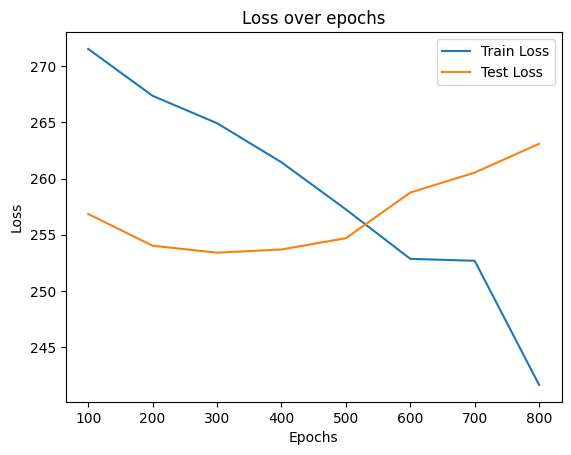

In [1118]:
losses_graph = np.array(losses_graph)
plt.plot(losses_graph[:, 0], losses_graph[:, 1], label='Train Loss')
plt.plot(losses_graph[:, 0], losses_graph[:, 2], label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1123]:
print(len(test_outputs))
print(testing_target_tensor[0])

# losses_graph = np.array(losses_graph)
# plt.plot(range(1, len(test_outputs)), test_outputs[:, 0], label='Train Loss')
# plt.plot(range(1, len(test_outputs)), testing_target_tensor[:, 0], label='Test Loss')
# plt.title('Loss over epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

for result in range(len(test_outputs)):
    print(f'Test: {test_outputs[result][0].item()} \t Truth: {testing_target_tensor[result][0].item()}')



82710
tensor([54.])
Test: 6.937122344970703 	 Truth: 54.0
Test: 4.649322509765625 	 Truth: 8.0
Test: 14.245745658874512 	 Truth: 37.0
Test: 4.761197566986084 	 Truth: 1.0
Test: 4.056665420532227 	 Truth: 1.0
Test: 4.7732768058776855 	 Truth: 1.0
Test: 5.28743314743042 	 Truth: 2.0
Test: 5.308826446533203 	 Truth: 69.0
Test: 20.20134162902832 	 Truth: 4.0
Test: 7.236579895019531 	 Truth: 2.0
Test: 4.986647129058838 	 Truth: 1.0
Test: 7.570762634277344 	 Truth: 2.0
Test: 6.581736087799072 	 Truth: 2.0
Test: 3.2122340202331543 	 Truth: 1.0
Test: 5.230792999267578 	 Truth: 1.0
Test: 6.74584436416626 	 Truth: 1.0
Test: 7.5821638107299805 	 Truth: 1.0
Test: 4.338198661804199 	 Truth: 2.0
Test: 11.169233322143555 	 Truth: 1.0
Test: 2.8244402408599854 	 Truth: 1.0
Test: 6.563800811767578 	 Truth: 9.0
Test: 5.683178424835205 	 Truth: 1.0
Test: 4.860671043395996 	 Truth: 1.0
Test: 3.6118013858795166 	 Truth: 13.0
Test: 8.835189819335938 	 Truth: 2.0
Test: 15.728246688842773 	 Truth: 3.0
Test: 6.